<a href="https://colab.research.google.com/github/syedmahmoodiagents/transformers/blob/main/Minimal_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

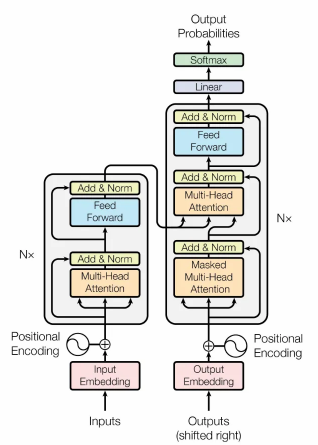

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value, mask=None):
        B, Tq, C = query.shape
        _, Tk, _ = key.shape

        Q = self.q_proj(query).reshape(B, Tq, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(key).reshape(B, Tk, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(value).reshape(B, Tk, self.num_heads, self.head_dim).transpose(1, 2)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)
        out = torch.matmul(attn_weights, V)
        out = out.transpose(1, 2).reshape(B, Tq, C)
        return self.out_proj(out)


In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, mask=None):
        # Self-attention (no causal mask)
        attn_out = self.self_attn(x, x, x, mask)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        return self.norm2(x + ff_out)


In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)  # masked self-attn
        self.cross_attn = MultiHeadAttention(embed_dim, num_heads) # cross-attn
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

    def forward(self, x, enc_out, tgt_mask=None, memory_mask=None):
        # 1. Masked self-attention
        attn_out = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + attn_out)

        # Cross-attention (Q from decoder, K/V from encoder output)
        cross_out = self.cross_attn(x, enc_out, enc_out, memory_mask)
        x = self.norm2(x + cross_out)

        # 3. Feed forward
        ff_out = self.ff(x)
        return self.norm3(x + ff_out)


In [ ]:
def generate_causal_mask(seq_len):
    return torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).unsqueeze(0)  # (1,1,L,L)


In [ ]:

torch.manual_seed(0)
batch_size = 1
src_len = 6
tgt_len = 5
embed_dim = 16
num_heads = 4
ff_dim = 64

# Duumy data english
encoder_in = torch.randn(batch_size, src_len, embed_dim)

# Dummy data for dutch
decoder_in = torch.randn(batch_size, tgt_len, embed_dim)


In [ ]:
tgt_mask = generate_causal_mask(tgt_len)  # look-ahead mask for decoder

In [ ]:
encoder_layer = EncoderLayer(embed_dim, num_heads, ff_dim)
encoder_out = encoder_layer(encoder_in)  # self-attention only

In [ ]:
# Decoder
decoder_layer = DecoderLayer(embed_dim, num_heads, ff_dim)
decoder_out = decoder_layer(decoder_in, encoder_out, tgt_mask=tgt_mask)

In [ ]:
print("Encoder output:", encoder_out.shape)
print("Decoder output:", decoder_out.shape)


Encoder output: torch.Size([1, 6, 16])
Decoder output: torch.Size([1, 5, 16])


# With Real Data

In [ ]:

pairs = [
    ("i am hungry", "ik ben hongerig"),
    ("he is tired", "hij is moe"),
    ("she is happy", "zij is blij"),
    ("she is not tired", "zij is niet moe"),
    ("he is not happy", "hij is niet blij"),
]

In [ ]:
def tokenize(text):
    return text.lower().split()


In [ ]:

def build_vocab(sentences):
    vocab = {"<PAD>": 0, "<BOS>": 1, "<EOS>": 2, "<UNK>": 3}
    for sentence in sentences:
        for token in tokenize(sentence):
            if token not in vocab:
                vocab[token] = len(vocab)
    return vocab


In [ ]:
src_sentences = [src for src, _ in pairs]
tgt_sentences = [tgt for _, tgt in pairs]

In [ ]:
src_vocab = build_vocab(src_sentences)
tgt_vocab = build_vocab(tgt_sentences)

In [ ]:
inv_tgt_vocab = {idx: tok for tok, idx in tgt_vocab.items()}

In [ ]:

def encode(sentence, vocab, add_eos=False, add_bos=False):
    tokens = []
    if add_bos:
        tokens.append(vocab["<BOS>"])
    for t in tokenize(sentence):
        tokens.append(vocab.get(t, vocab["<UNK>"]))
    if add_eos:
        tokens.append(vocab["<EOS>"])
    return tokens


In [ ]:

class TranslationDataset(Dataset):
    def __init__(self, pairs):
        self.data = pairs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        src_ids = encode(src, src_vocab, add_eos=True)
        tgt_in = encode(tgt, tgt_vocab, add_bos=True)
        tgt_out = encode(tgt, tgt_vocab, add_eos=True)
        return src_ids, tgt_in, tgt_out


In [ ]:

def collate_fn(batch):
    src_batch, tgt_in_batch, tgt_out_batch = zip(*batch)
    src_max_len = max(len(s) for s in src_batch)
    tgt_max_len = max(len(t) for t in tgt_in_batch)

    src_pad = []
    tgt_in_pad = []
    tgt_out_pad = []
    for s, ti, to in zip(src_batch, tgt_in_batch, tgt_out_batch):
        src_pad.append(s + [src_vocab["<PAD>"]] * (src_max_len - len(s)))
        tgt_in_pad.append(ti + [tgt_vocab["<PAD>"]] * (tgt_max_len - len(ti)))
        tgt_out_pad.append(to + [tgt_vocab["<PAD>"]] * (tgt_max_len - len(to)))

    return (
        torch.tensor(src_pad, dtype=torch.long),
        torch.tensor(tgt_in_pad, dtype=torch.long),
        torch.tensor(tgt_out_pad, dtype=torch.long),
    )


In [ ]:
dataset = TranslationDataset(pairs)

In [ ]:
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [ ]:

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, query, key, value, mask=None):
        B, Tq, C = query.shape
        Tk = key.shape[1]

        Q = self.q_proj(query).reshape(B, Tq, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(key).reshape(B, Tk, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(value).reshape(B, Tk, self.num_heads, self.head_dim).transpose(1, 2)

        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = F.softmax(attn_scores, dim=-1)
        out = torch.matmul(attn_weights, V)
        out = out.transpose(1, 2).reshape(B, Tq, C)
        return self.out_proj(out)


In [ ]:

class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x, src_mask=None):
        attn_out = self.self_attn(x, x, x, src_mask)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        return self.norm2(x + ff_out)


In [ ]:

class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super().__init__()
        self.self_attn = MultiHeadAttention(embed_dim, num_heads)  # masked
        self.cross_attn = MultiHeadAttention(embed_dim, num_heads) # encoder-decoder
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

    def forward(self, x, enc_out, tgt_mask=None, memory_mask=None):
        attn_out = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + attn_out)
        cross_out = self.cross_attn(x, enc_out, enc_out, memory_mask)
        x = self.norm2(x + cross_out)
        ff_out = self.ff(x)
        return self.norm3(x + ff_out)


In [ ]:
def generate_causal_mask(seq_len):
    return torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).unsqueeze(0)


In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim=32, num_heads=4, ff_dim=64, num_layers=2):
        super().__init__()
        self.src_embed = nn.Embedding(src_vocab_size, embed_dim)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, embed_dim)

        self.encoder_layers = nn.ModuleList([EncoderLayer(embed_dim, num_heads, ff_dim) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(embed_dim, num_heads, ff_dim) for _ in range(num_layers)])

        self.fc_out = nn.Linear(embed_dim, tgt_vocab_size)

    def forward(self, src, tgt_in):
        src_emb = self.src_embed(src)
        tgt_emb = self.tgt_embed(tgt_in)

        enc_out = src_emb
        for layer in self.encoder_layers:
            enc_out = layer(enc_out)

        tgt_mask = generate_causal_mask(tgt_in.size(1)).to(tgt_in.device)
        dec_out = tgt_emb
        for layer in self.decoder_layers:
            dec_out = layer(dec_out, enc_out, tgt_mask=tgt_mask)

        return self.fc_out(dec_out)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Transformer(len(src_vocab), len(tgt_vocab)).to(device)

model = Transformer(len(src_vocab), len(tgt_vocab))

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab["<PAD>"])

In [ ]:

for epoch in range(50):
    model.train()
    total_loss = 0
    for src, tgt_in, tgt_out in dataloader:
        src, tgt_in, tgt_out = src.to(device), tgt_in.to(device), tgt_out.to(device)
        logits = model(src, tgt_in)  # (B, T, vocab_size)
        loss = criterion(logits.view(-1, logits.size(-1)), tgt_out.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 10, Loss: 0.0953
Epoch 20, Loss: 0.0079
Epoch 30, Loss: 0.0037
Epoch 40, Loss: 0.0025
Epoch 50, Loss: 0.0018


In [ ]:

def translate(sentence, max_len=10):
    model.eval()
    src_ids = encode(sentence, src_vocab, add_eos=True)
    src_tensor = torch.tensor([src_ids], dtype=torch.long).to(device)
    enc_out = model.src_embed(src_tensor)
    for layer in model.encoder_layers:
        enc_out = layer(enc_out)

    tgt_ids = [tgt_vocab["<BOS>"]]
    for _ in range(max_len):
        tgt_tensor = torch.tensor([tgt_ids], dtype=torch.long).to(device)
        tgt_mask = generate_causal_mask(tgt_tensor.size(1)).to(device)
        dec_out = model.tgt_embed(tgt_tensor)
        for layer in model.decoder_layers:
            dec_out = layer(dec_out, enc_out, tgt_mask=tgt_mask)
        logits = model.fc_out(dec_out)
        next_id = logits[0, -1].argmax().item()
        if next_id == tgt_vocab["<EOS>"]:
            break
        tgt_ids.append(next_id)

    return " ".join(inv_tgt_vocab[i] for i in tgt_ids[1:])

In [ ]:
print(translate("i am hungry"))
print(translate("he is tired"))
print(translate("she is happy"))

ik ben hongerig
hij is moe
zij is blij
